
# Real-Time Sentiment Analyzer — End-to-End (spaCy + TextBlob + Flask)

This notebook builds a complete sentiment analysis project:
- **Data**: IMDB reviews (CSV)
- **NLP**: spaCy for tokenization/lemmatization; TextBlob for baseline sentiment (optional)
- **Models**: Logistic Regression (main), optional SVM and optional BERT
- **Backend**: Flask app for real-time predictions + optional tweets loader
- **Visualizations**: Pie chart, timeline (if tweets), word clouds, and key influencing words

> **Note:** Run the cells **in order**. Installation cell first. Update file paths as needed on your machine.


## 1) Setup & Installation

In [1]:

# If running locally, uncomment the following line to install dependencies
%pip install -U spacy textblob scikit-learn wordcloud matplotlib flask tweepy fastapi uvicorn transformers torch joblib

# Download spaCy English model if not installed
!python -m spacy download en_core_web_sm


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------------- 624.3/624.3 kB 17.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------  8.7/8.7 MB 88.9 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 33.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------------- ------- 6.6/8.1 MB 33.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 19.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ----------------- ---------------------- 5.0/11.3 MB 24.0 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.3 MB 28.0 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 21.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/561.5 kB ? eta -:--:--
   -----------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 12.8/12.8 MB 61.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2) Imports & Globals

In [2]:

import os
import re
import json
import time
import math
import random
import joblib
import string
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from textblob import TextBlob

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# Paths (change if needed)
DATA_PATH = Path('IMDB_Dataset_Reviews.csv')  # Update to your local path if different
ARTIFACT_DIR = Path('./artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)


## 3) Data Loading (IMDB Dataset)

In [3]:

# EXPECTED CSV COLUMNS: 'review' and 'sentiment' (sentiment in {'positive','negative'})
# If your CSV uses different column names, change them here.
df = pd.read_csv(DATA_PATH)

# Standardize column names if needed
df.columns = [c.strip().lower() for c in df.columns]
if 'review' not in df.columns or 'sentiment' not in df.columns:
    raise ValueError("CSV must contain 'review' and 'sentiment' columns. Found: %s" % df.columns.tolist())

print(df.head(3))
print('\nClass balance:')
print(df['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive

Class balance:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64



## 4) Preprocessing (spaCy)
- Lowercasing
- Remove punctuation/digits
- Tokenization
- Stopword removal
- Lemmatization

We produce a cleaned text column for vectorization.


In [13]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])  # speed up preprocessing

def spacy_clean(text: str) -> str:
    """Clean + tokenize + lemmatize with spaCy.
    Steps: lowercase, remove digits/punct, remove stopwords/spaces, remove html breaks, lemmatize
    Returns a whitespace-joined string of lemmas.
    """
    text = text.lower()
    # Remove HTML line breaks and other tags
    text = re.sub(r'<br\s*/?>', ' ', text)  # handles <br>, <br/> and <br >
    text = re.sub(r'\d+', ' ', text)  # remove digits
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)  # remove punctuation
    doc = nlp(text)
    lemmas = []
    for tok in doc:
        if tok.is_space or tok.is_punct or tok.is_stop:
            continue
        lemma = tok.lemma_.strip()
        if lemma:
            lemmas.append(lemma)
    return ' '.join(lemmas)

# Sample cleaning to estimate time
sample = df['review'].iloc[0]
print('Sample (raw)    :', sample[:120].replace('\n',' ') + '...')
print('Sample (cleaned):', spacy_clean(sample)[:120] + '...')

# Clean the whole dataset (this may take a few minutes depending on size)
df['clean'] = df['review'].astype(str).apply(spacy_clean)
df = df.dropna(subset=['clean','sentiment']).reset_index(drop=True)


Sample (raw)    : One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this...
Sample (cleaned): reviewer mention watch oz episode ll hook right exactly happen thing strike oz brutality unflinche scene violence set ri...


## 5) Vectorization (TF-IDF)

In [14]:

# TF-IDF on cleaned/lemmatized text
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.95)
X = tfidf.fit_transform(df['clean'].values)
y = df['sentiment'].str.lower().map({'positive':1, 'negative':0}).values

print('Shape (X):', X.shape, '| Positive rate:', y.mean().round(3))


Shape (X): (50000, 157227) | Positive rate: 0.5


## 6) Train/Test Split

In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train:', X_train.shape, ' Test:', X_test.shape)


Train: (40000, 157227)  Test: (10000, 157227)



## 7) Model Training
We train two classical models:
- **Logistic Regression** (primary, provides probabilities for confidence)
- **LinearSVC** with **CalibratedClassifierCV** (to get probabilities)

> If you only need one, Logistic Regression is sufficient and simpler.


In [16]:

# Logistic Regression (primary)
logit = LogisticRegression(max_iter=1000, n_jobs=None)
logit.fit(X_train, y_train)

# Optional: LinearSVC + calibration for probabilities
svc = LinearSVC()
svc_cal = CalibratedClassifierCV(svc, cv=3)
svc_cal.fit(X_train, y_train)

# Choose your production model here:
production_model = logit  # or svc_cal


## 8) Evaluation (Accuracy, F1, Report, Confusion Matrix)

[LogisticRegression] Accuracy: 0.8981 | F1: 0.8995

              precision    recall  f1-score   support

    negative       0.91      0.88      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[LinearSVC (calibrated)] Accuracy: 0.9082 | F1: 0.9087

              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



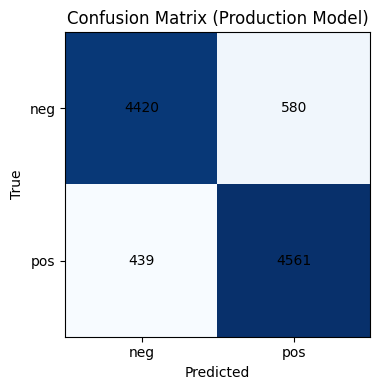

In [17]:

def evaluate(model, X_te, y_te, name='model'):
    pred = model.predict(X_te)
    acc = accuracy_score(y_te, pred)
    f1 = f1_score(y_te, pred)
    print(f'[{name}] Accuracy: {acc:.4f} | F1: {f1:.4f}\n')
    print(classification_report(y_te, pred, target_names=['negative','positive']))
    cm = confusion_matrix(y_te, pred)
    return {'pred': pred, 'acc':acc, 'f1':f1, 'cm':cm}

res_logit = evaluate(logit, X_test, y_test, 'LogisticRegression')
res_svc   = evaluate(svc_cal, X_test, y_test, 'LinearSVC (calibrated)')

# Plot confusion matrix for chosen model
cm = confusion_matrix(y_test, production_model.predict(X_test))
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap='Blues')
ax.set_title('Confusion Matrix (Production Model)')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels(['neg','pos']); ax.set_yticklabels(['neg','pos'])
for (i,j), val in np.ndenumerate(cm):
    ax.text(j, i, str(val), ha='center', va='center')
plt.tight_layout()
plt.show()


## 9) K-fold Cross-Validation (Stratified 5-fold)

In [18]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X, y, cv=cv, scoring='f1')
print('5-fold F1 scores:', np.round(cv_scores, 4))
print('Mean F1:', cv_scores.mean().round(4), '| Std:', cv_scores.std().round(4))


5-fold F1 scores: [0.8955 0.8977 0.8953 0.8941 0.8933]
Mean F1: 0.8952 | Std: 0.0015



## 10) Confidence Scores & Neutral Class
We derive **confidence** from predicted probabilities.  
If the probability gap between Positive and Negative is small (e.g., `< 0.1`), classify as **Neutral**.


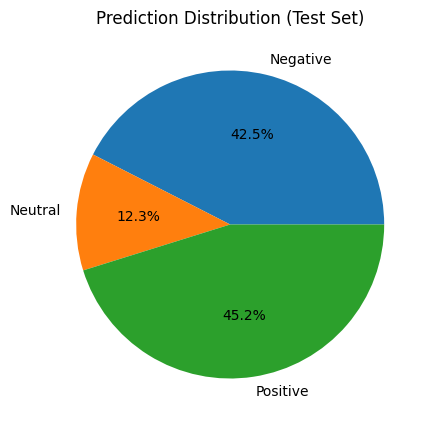

In [19]:

def predict_with_confidence(model, X_batch, neutral_margin=0.1):
    # Probability for positive class
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X_batch)[:,1]
    else:
        # For calibrated SVC
        probs = model.predict_proba(X_batch)[:,1]
    # Confidence is distance from 0.5
    conf = np.abs(probs - 0.5) * 2  # range [0,1]
    labels = np.where(conf < neutral_margin*2, 2, (probs >= 0.5).astype(int))  # 2=neutral
    return labels, probs, conf

labels, probs, conf = predict_with_confidence(production_model, X_test)
label_names = np.array(['Negative','Positive','Neutral'])
pred_names = label_names[labels]

# Pie chart of predicted labels
values = Counter(pred_names)
plt.figure(figsize=(5,5))
plt.pie(values.values(), labels=values.keys(), autopct='%1.1f%%')
plt.title('Prediction Distribution (Test Set)')
plt.show()


## 11) Key Influencing Words (Top TF-IDF Coefficients)

In [20]:

def top_features_for_logreg(model, vectorizer, k=20):
    if not hasattr(model, 'coef_'):
        print("Top features only implemented for linear models with coef_.")
        return
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_[0]
    top_pos_idx = np.argsort(coefs)[-k:][::-1]
    top_neg_idx = np.argsort(coefs)[:k]
    print("\nTop positive indicators:")
    for i in top_pos_idx:
        print(f"{feature_names[i]}  ({coefs[i]:.3f})")
    print("\nTop negative indicators:")
    for i in top_neg_idx:
        print(f"{feature_names[i]}  ({coefs[i]:.3f})")

top_features_for_logreg(production_model, tfidf, k=25)



Top positive indicators:
great  (9.205)
excellent  (7.855)
love  (6.082)
perfect  (5.918)
wonderful  (5.578)
amazing  (5.560)
good  (5.556)
favorite  (5.153)
enjoy  (5.068)
brilliant  (4.790)
fun  (4.788)
hilarious  (4.668)
today  (4.331)
superb  (4.116)
definitely  (4.074)
fantastic  (3.962)
enjoyable  (3.754)
highly  (3.693)
highly recommend  (3.662)
beautiful  (3.597)
classic  (3.439)
funniest  (3.368)
entertaining  (3.349)
especially  (3.332)
perfectly  (3.323)

Top negative indicators:
bad  (-13.765)
waste  (-9.161)
awful  (-8.440)
boring  (-7.137)
poor  (-6.760)
terrible  (-6.286)
fail  (-5.746)
dull  (-5.400)
horrible  (-5.337)
suppose  (-5.211)
stupid  (-5.148)
poorly  (-5.065)
instead  (-5.043)
lack  (-5.043)
minute  (-4.919)
waste time  (-4.620)
unfortunately  (-4.567)
disappointment  (-4.467)
save  (-4.465)
annoying  (-4.459)
lame  (-4.454)
script  (-4.398)
disappointing  (-4.369)
ridiculous  (-4.320)
avoid  (-4.031)


## 12) Word Clouds (Positive vs Negative)

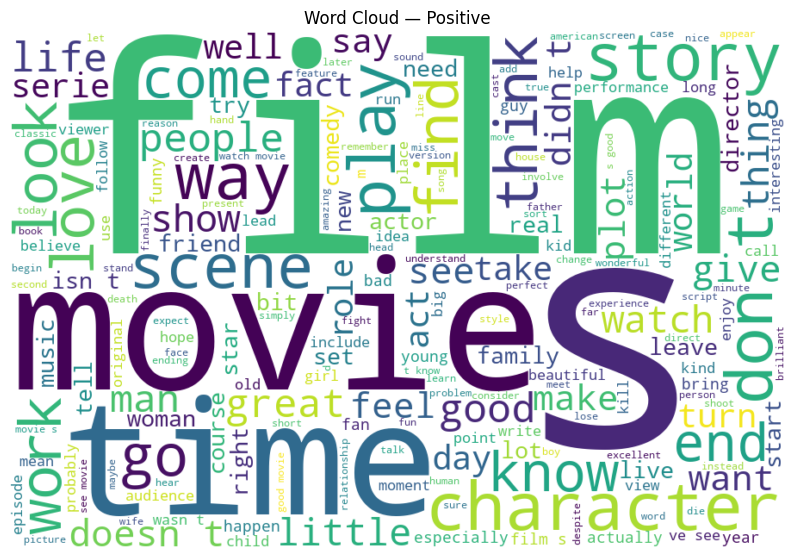

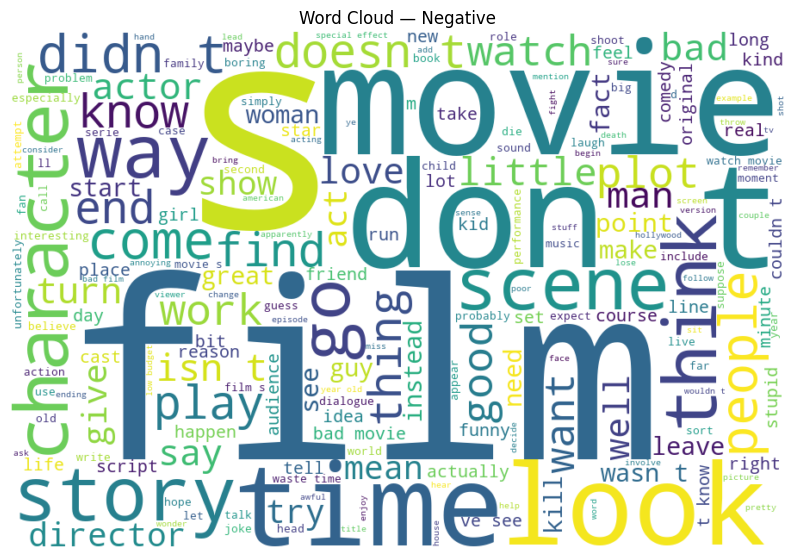

In [21]:

pos_text = ' '.join(df.loc[df['sentiment'].str.lower()=='positive','clean'].tolist())
neg_text = ' '.join(df.loc[df['sentiment'].str.lower()=='negative','clean'].tolist())

wc_pos = WordCloud(width=900, height=600, background_color='white').generate(pos_text)
wc_neg = WordCloud(width=900, height=600, background_color='white').generate(neg_text)

plt.figure(figsize=(10,7))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud — Positive')
plt.show()

plt.figure(figsize=(10,7))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud — Negative')
plt.show()


## 13) Save Artifacts (Model + Vectorizer)

In [22]:

joblib.dump(production_model, ARTIFACT_DIR / 'model.pkl')
joblib.dump(tfidf, ARTIFACT_DIR / 'tfidf.pkl')
print('Saved:', list(ARTIFACT_DIR.glob('*.pkl')))


Saved: [WindowsPath('artifacts/model.pkl'), WindowsPath('artifacts/tfidf.pkl')]



## 14) Flask App — Real-Time Sentiment
- `/` : Input form
- `/predict` : Returns label + confidence
- `/tweets` : (Optional) Load tweets by keyword (requires Twitter/X API keys) and visualize

> Run the Flask app **after** training the model so it can load `artifacts/model.pkl` and `artifacts/tfidf.pkl`.


In [ ]:

# This cell writes a minimal Flask app to app.py (run it after training)
app_py = """
import os
import re
import joblib
import numpy as np
from flask import Flask, request, render_template_string
import spacy

APP_DIR = os.path.dirname(os.path.abspath(__file__))
MODEL_PATH = os.path.join(APP_DIR, 'artifacts', 'model.pkl')
VECT_PATH  = os.path.join(APP_DIR, 'artifacts', 'tfidf.pkl')

nlp = spacy.load("en_core_web_sm", disable=['ner','parser'])
model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECT_PATH)

def spacy_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    doc = nlp(text)
    lemmas = []
    for tok in doc:
        if tok.is_space or tok.is_punct or tok.is_stop:
            continue
        lemma = tok.lemma_.strip()
        if lemma:
            lemmas.append(lemma)
    return ' '.join(lemmas)

def predict_with_confidence(text: str, neutral_margin=0.1):
    clean = spacy_clean(text)
    X = vectorizer.transform([clean])
    if hasattr(model, 'predict_proba'):
        p = model.predict_proba(X)[0,1]
    else:
        p = model.predict_proba(X)[0,1]
    conf = abs(p - 0.5) * 2
    if conf < neutral_margin*2:
        label = 'Neutral'
    else:
        label = 'Positive' if p >= 0.5 else 'Negative'
    return label, float(p), float(conf)

HTML = '''
<!doctype html>
<title>Real-Time Sentiment</title>
<h2>Real-Time Sentiment (IMDB model)</h2>
<form method="post" action="/predict">
  <textarea name="text" rows="6" cols="80" placeholder="Type or paste text here..."></textarea><br><br>
  <button type="submit">Analyze</button>
</form>
{% if result %}
  <h3>Result</h3>
  <p><b>Label:</b> {{ result['label'] }}</p>
  <p><b>Positive Probability:</b> {{ '{:.3f}'.format(result['prob']) }}</p>
  <p><b>Confidence:</b> {{ '{:.3f}'.format(result['conf']) }}</p>
{% endif %}
'''

app = Flask(__name__)

@app.route('/', methods=['GET'])
def home():
    return render_template_string(HTML, result=None)

@app.route('/predict', methods=['POST'])
def predict():
    text = request.form.get('text','')
    label, prob, conf = predict_with_confidence(text)
    return render_template_string(HTML, result={'label':label,'prob':prob,'conf':conf})

if __name__ == '__main__':
    # Run:  python app.py
    # Then open http://127.0.0.1:5000
    app.run(host='0.0.0.0', port=5000, debug=True)
"""

with open('app.py', 'w', encoding='utf-8') as f:
    f.write(app_py)

print("Flask app written to app.py. Launch it with:")
print("  python app.py   (after running the training cells above)")



## 15) (Optional) Tweets Loader for Live Inference
Requires **Twitter/X API** credentials. Uncomment and configure if you have access.


In [ ]:

# Example (commented out):
# import tweepy
#
# API_KEY = 'YOUR_KEY'
# API_SECRET = 'YOUR_SECRET'
# ACCESS_TOKEN = 'YOUR_ACCESS_TOKEN'
# ACCESS_SECRET = 'YOUR_ACCESS_SECRET'
#
# auth = tweepy.OAuth1UserHandler(API_KEY, API_SECRET, ACCESS_TOKEN, ACCESS_SECRET)
# api = tweepy.API(auth)
#
# def fetch_tweets(keyword='coldplay', max_items=50):
#     tweets = []
#     for status in tweepy.Cursor(api.search_tweets, q=keyword, lang='en', tweet_mode='extended').items(max_items):
#         txt = status.full_text
#         tweets.append({'created_at': status.created_at, 'text': txt})
#     return pd.DataFrame(tweets)
#
# # Example usage:
# # tw = fetch_tweets('movie reviews', max_items=100)
# # tw['clean'] = tw['text'].apply(spacy_clean)
# # X_tw = tfidf.transform(tw['clean'])
# # labels, probs, conf = predict_with_confidence(production_model, X_tw)
# # tw['pred'] = labels
# # tw['prob'] = probs
# # tw['conf'] = conf
# #
# # # Timeline plot (by created_at)
# # tw_sorted = tw.sort_values('created_at')
# # # Map labels to numeric for plotting: Pos=1, Neg=0, Neutral=0.5
# # mapping = {0:0, 1:1, 2:0.5}
# # nums = [mapping[x] for x in tw_sorted['pred']]
# # plt.figure(figsize=(10,4))
# # plt.plot(tw_sorted['created_at'], nums, marker='o')
# # plt.title('Sentiment Timeline (Tweets)')
# # plt.ylabel('Sentiment (0=Neg, 0.5=Neutral, 1=Pos)')
# # plt.xticks(rotation=45)
# # plt.tight_layout()
# # plt.show()



## 16) (Optional) BERT Fine-Tuning
> **Resource-heavy**. Only attempt if you have a GPU or patience.  
This section shows a minimal approach using `transformers` to create embeddings (no full fine-tuning in this example), then trains Logistic Regression on top.


In [ ]:

# Minimal BERT embeddings pipeline (commented to avoid heavy downloads during first run)
# from transformers import AutoTokenizer, AutoModel
# import torch
#
# MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
# tok = AutoTokenizer.from_pretrained(MODEL_NAME)
# bert = AutoModel.from_pretrained(MODEL_NAME)
#
# def mean_pool(last_hidden_state, attention_mask):
#     mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#     return torch.sum(last_hidden_state * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)
#
# def bert_embed(texts, batch_size=64):
#     vecs = []
#     for i in range(0, len(texts), batch_size):
#         batch = texts[i:i+batch_size]
#         enc = tok(batch, padding=True, truncation=True, return_tensors='pt', max_length=256)
#         with torch.no_grad():
#             out = bert(**enc)
#         emb = mean_pool(out.last_hidden_state, enc['attention_mask'])
#         vecs.append(emb.cpu().numpy())
#     return np.vstack(vecs)
#
# # Example sketch (you need to adapt slices accordingly):
# # Xb_train = bert_embed(df['review'].iloc[:1000].tolist())
# # yb_train = df['sentiment'].iloc[:1000].str.lower().map({'positive':1,'negative':0}).values
# # clf = LogisticRegression(max_iter=1000).fit(Xb_train, yb_train)


## 17) (Optional) TextBlob Baseline

In [ ]:

def textblob_polarity_label(txt):
    p = TextBlob(txt).sentiment.polarity  # range [-1,1]
    if p > 0.1: return 1
    if p < -0.1: return 0
    return 2  # Neutral
tb_preds = [textblob_polarity_label(t) for t in df['review'].iloc[:200].tolist()]
print('Sample TextBlob predictions (first 20):', tb_preds[:20])



## 18) Next Steps
- Try different `TfidfVectorizer` settings and model hyperparameters
- Adjust the **neutral margin** to fit your use case
- Add caching to preprocessing if dataset is large
- Secure the Flask app if deploying
- Deploy behind a production server (e.g., gunicorn + nginx) or as a container
